## Formula One Exploratory Data Analysis

First, let's import all the libraries we will use to analyze and visualize the source data.

In [759]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Now, let's read all the CSV files from the src folder into pandas dataframes so we can start exploring the data.

In [760]:
constructors = pd.read_csv('src/constructors.csv')
constructor_results = pd.read_csv('src/constructor_results.csv')
constructor_standings = pd.read_csv('src/constructor_results.csv') 

drivers = pd.read_csv('src/drivers.csv')
driver_standings = pd.read_csv('src/driver_standings.csv')

races = pd.read_csv('src/races.csv')
circuits = pd.read_csv('src/circuits.csv')
seasons = pd.read_csv('src/seasons.csv')

results = pd.read_csv('src/results.csv')
sprint_results = pd.read_csv('src/sprint_results.csv')

lap_times = pd.read_csv('src/lap_times.csv')
qualifying = pd.read_csv('src/qualifying.csv')
pit_stops = pd.read_csv('src/pit_stops.csv')

status = pd.read_csv('src/status.csv')

Now that all our CSVs are stored in pandas dataframes, the next step is to check how clean the data is. It's critical to not skip this step because it can easily cause problems and unpredictable behavior down the line if the data is not clean.

Let's focus on the drivers and driver_standings data first.

In [761]:
drivers.info()
drivers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     859 non-null    int64 
 1   driverRef    859 non-null    object
 2   number       859 non-null    object
 3   code         859 non-null    object
 4   forename     859 non-null    object
 5   surname      859 non-null    object
 6   dob          859 non-null    object
 7   nationality  859 non-null    object
 8   url          859 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.5+ KB


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [762]:
driver_standings.info()
driver_standings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34595 entries, 0 to 34594
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   driverStandingsId  34595 non-null  int64  
 1   raceId             34595 non-null  int64  
 2   driverId           34595 non-null  int64  
 3   points             34595 non-null  float64
 4   position           34595 non-null  int64  
 5   positionText       34595 non-null  object 
 6   wins               34595 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 1.8+ MB


,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


Just from this info, we can see that the data is very clean. Because the non-null counts match the number of entries, we can right tell that there are no missing values. We can count the number of null cells in each column separately too, just to make sure. 

In [763]:
drivers.isna().sum()

driverId       0
driverRef      0
number         0
code           0
forename       0
surname        0
dob            0
nationality    0
url            0
dtype: int64

In [764]:
driver_standings.isna().sum()

driverStandingsId    0
raceId               0
driverId             0
points               0
position             0
positionText         0
wins                 0
dtype: int64

Ok now let's try to find the career wins for each driver in the dataset.

In [765]:
final_race_of_season = races.loc[races.groupby('year')['round'].idxmax(), ['raceId','year']]
career_wins = final_race_of_season.merge(driver_standings, on='raceId', how='left').groupby('driverId')['wins'].sum().reset_index()
career_wins = career_wins.sort_values(by='wins', ascending=False)
career_wins.head()

,driverId,wins
0,1.0,103.0
28,30.0,91.0
821,830.0,54.0
19,20.0,53.0
113,117.0,51.0


Now let's look at how the career wins for each driver are distributed

In [766]:
career_wins['wins'].describe()

count    851.000000
mean       1.297297
std        6.695194
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      103.000000
Name: wins, dtype: float64

<Axes: xlabel='wins', ylabel='Count'>

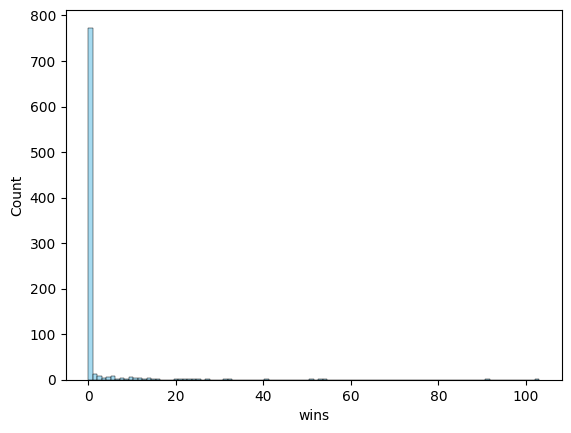

In [767]:
sns.histplot(career_wins['wins'], color='skyblue', bins=100)

The distribution of career wins is clearly very skewed to the right. The vast majority of drivers have less than 50 wins in their entire careers with only a handful of drivers exceeding 200 wins.

I think the majority of drivers will have zero wins in their careers, let's see if this is true. Maybe we will find some new insights if we drop the zero win drivers.

In [768]:
drivers_zero_wins_percent = career_wins[career_wins['wins'] == 0][['driverId']].count() / career_wins.shape[0]
print(drivers_zero_wins_percent * 100)


driverId    86.721504
dtype: float64


Now we know that 86.6% of F1 drivers since 1950 never won a race. Many drivers drove uncompetitive cars their entire careers and never won a race as a result. Let's see what the career wins distribution looks like if we drop the drivers that never won a race. I expect it will still be extremely right-skewed, but less dramatically so.   

         driverId        wins
count  113.000000  113.000000
mean   317.716814    9.769912
std    253.274536   16.021196
min      1.000000    1.000000
25%    105.000000    1.000000
50%    250.000000    4.000000
75%    479.000000   11.000000
max    847.000000  103.000000


<Axes: xlabel='wins', ylabel='Count'>

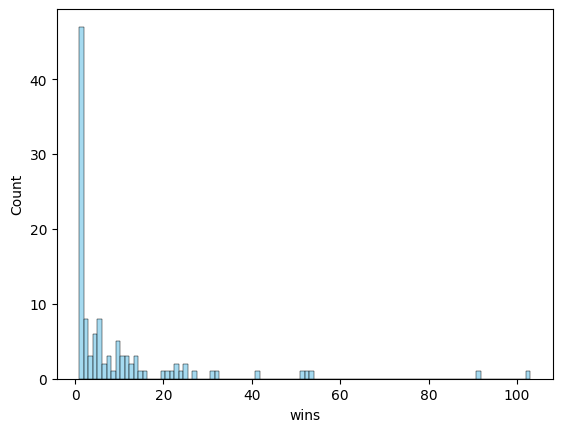

In [769]:
career_stats_winners = career_wins[career_wins['wins'] != 0]
print(career_stats_winners.describe())
sns.histplot(career_stats_winners['wins'], color='skyblue', bins=100)


As predicted, the plot is still extremely right-skewed with a majority of drivers only winning a handful of races and a tiny minority winning more than 200 races. However, this plot does not give us a full picture of how successful each driver was as it does not take into consideration the total number of races the driver participated in. Let's calculate and visualize each driver's win rate.

In [770]:
career_race_starts = results.groupby('driverId')['raceId'].count().reset_index(name='career_race_starts')
career_race_starts = career_race_starts.sort_values(by='career_race_starts', ascending=False)

career_wins = career_wins.merge(career_race_starts, on='driverId', how='left').rename(columns={'career_race_starts':'race_starts'})
career_wins['win_rate'] = round((career_wins['wins'] / career_wins['race_starts']), 4)
career_wins.sort_values(by='win_rate', ascending=False, inplace=True)
career_wins = career_wins.merge(drivers, how='left', on='driverId')

career_wins.head()

,driverId,wins,race_starts,win_rate,driverRef,number,code,forename,surname,dob,nationality,url
0,766.0,1.0,2,0.5000,wallard,\N,\N,Lee,Wallard,1910-09-07,American,http://en.wikipedia.org/wiki/Lee_Wallard
1,579.0,24.0,58,0.4138,fangio,\N,\N,Juan,Fangio,1911-06-24,Argentine,http://en.wikipedia.org/wiki/Juan_Manuel_Fangio
2,657.0,2.0,5,0.4000,vukovich,\N,\N,Bill,Vukovich,1918-12-13,American,http://en.wikipedia.org/wiki/Bill_Vukovich
3,647.0,13.0,36,0.3611,ascari,\N,\N,Alberto,Ascari,1918-07-13,Italian,http://en.wikipedia.org/wiki/Alberto_Ascari
4,373.0,25.0,73,0.3425,clark,\N,\N,Jim,Clark,1936-03-04,British,http://en.wikipedia.org/wiki/Jim_Clark


We now have wins, race_starts, and win_rate calculated for each driver. There are some clear outliers, though. The driver with the highest win rate of all time, for example, only started two races and won one of them. Despite having a 50% win rate on paper, I don't think this qualifies Lee Ward as the greatest driver of all time. Let's plot the top 30 drivers by win rate, ignoring drivers with less than 20 race starts.

,driverId,wins,race_starts,win_rate,driverRef,number,code,forename,surname,dob,nationality,url
1,579.0,24.0,58,0.4138,fangio,\N,\N,Juan,Fangio,1911-06-24,Argentine,http://en.wikipedia.org/wiki/Juan_Manuel_Fangio
3,647.0,13.0,36,0.3611,ascari,\N,\N,Alberto,Ascari,1918-07-13,Italian,http://en.wikipedia.org/wiki/Alberto_Ascari
4,373.0,25.0,73,0.3425,clark,\N,\N,Jim,Clark,1936-03-04,British,http://en.wikipedia.org/wiki/Jim_Clark
5,1.0,103.0,344,0.2994,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
6,30.0,91.0,308,0.2955,michael_schumacher,\N,MSC,Michael,Schumacher,1969-01-03,German,http://en.wikipedia.org/wiki/Michael_Schumacher


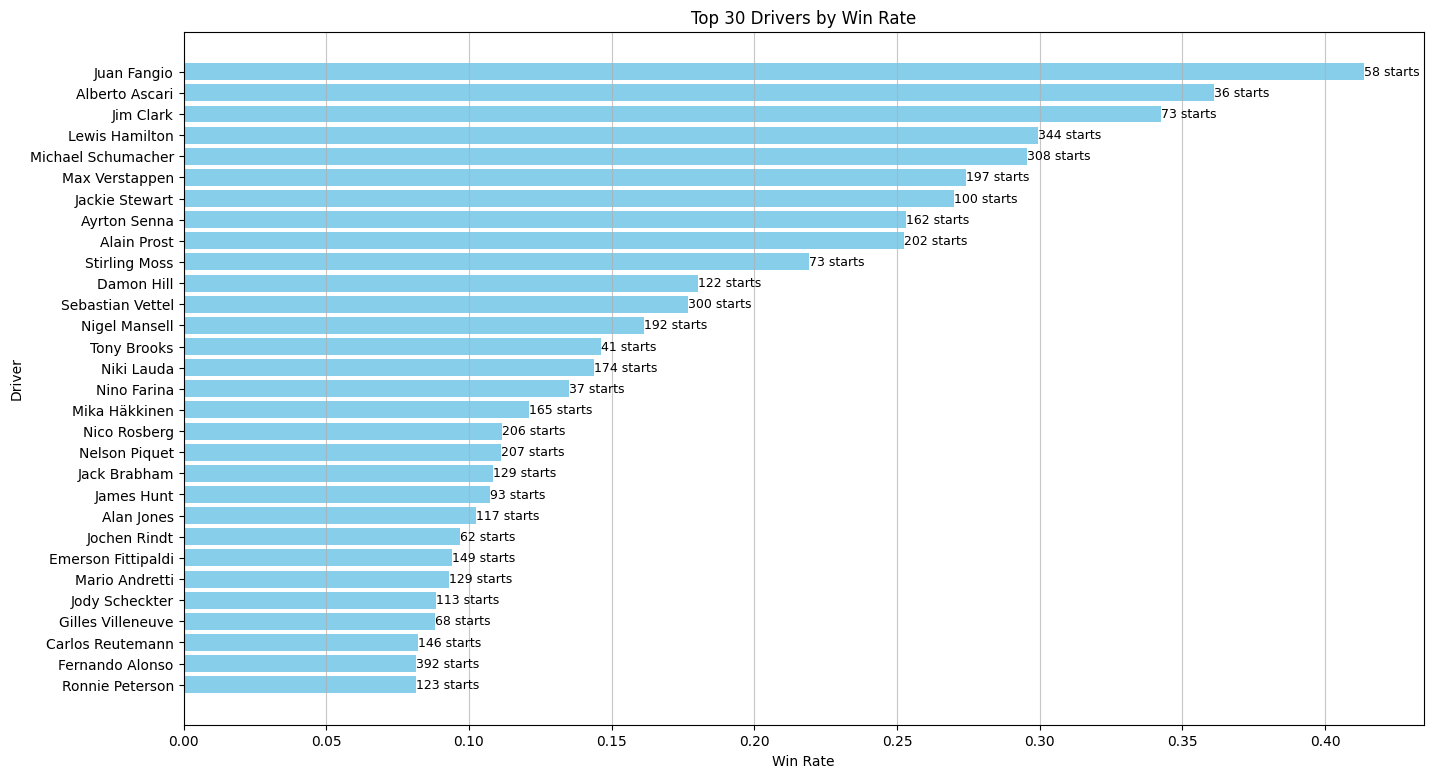

In [771]:
# Only consider drivers with >20 race starts
top_30 = career_wins[career_wins['race_starts'] > 20].head(30)

plt.figure(figsize=(16, 9))
bars = plt.barh(top_30['forename'] + " " + top_30['surname'], top_30['win_rate'], color='skyblue')
plt.title('Top 30 Drivers by Win Rate')
plt.xlabel('Win Rate')
plt.ylabel('Driver')
plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.gca().invert_yaxis()

for bar, start_count in zip(bars, top_30['race_starts']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f"{int(start_count)} starts", ha='left', va='center', fontsize=9)


top_30.head()

This simple win rate calculation is by no means a comprehensive way to find the best 30 drivers in Formula One history, but many of the greatest names in the sport do in fact appear in this list.